In [108]:
using Agents
using DynamicalSystems
using InteractiveDynamics
using GLMakie
using CairoMakie
using Plots
using StatsPlots

using GraphMakie
using Random
using Graphs
using GraphPlot
using Measures
using Compose, Cairo, Fontconfig

In [109]:
SEED = 123

123

In [122]:
# set up the dims of grid
const NN = 13
const GRID_DIM = (NN,NN)
TOTAL_AGENTS = round( Int, 0.75*prod(GRID_DIM) );
# make a lattice grid graph space
residential_graph = Graphs.grid( GRID_DIM, periodic=false )

{169, 312} undirected simple Int64 graph

In [123]:
fieldnames( typeof(residential_graph) )

(:ne, :fadjlist)

Generate a graph residential_graph, and for each node in the graph, it is randomly deciding whether to add or remove edges based on the specified THRESHOLD_RAND_ALTER probability. This code simulates the dynamic alteration of edges in the graph, possibly representing changes in connectivity or relationships between nodes.

In [127]:
# mutate the graph to have more or less edges than before
THRESHOLD_RAND_EDGE_ADD = 0.2
THRESHOLD_RAND_EDGE_RM = 0.2

for source_node in vertices(residential_graph)
    
    # add edge
    if( rand() < THRESHOLD_RAND_EDGE_ADD )
        destination_node = rand( 1:nv(residential_graph), 1)[1]
        
        if( destination_node != source_node )
            add_edge!(residential_graph, source_node, destination_node)
        end
    end
    
    # remove edge
    if( rand() < THRESHOLD_RAND_EDGE_RM )
        neighbors = all_neighbors(residential_graph, source_node)

        if( length(neighbors) > 0 )
            neighbor = rand( neighbors, 1)[1]
            rem_edge!(residential_graph, source_node, neighbor)
        end
    end
    
end
residential_graph

{169, 305} undirected simple Int64 graph

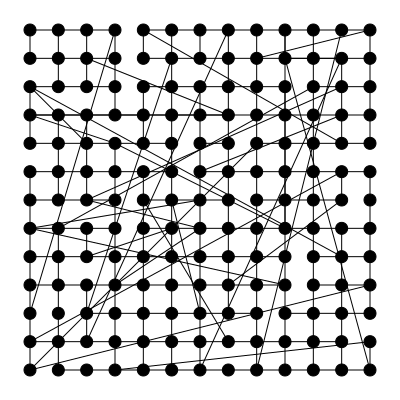

In [130]:
@drawsvg begin
    background("white")
    drawgraph(residential_graph, layout=squaregrid)
end 400 400

### Set up model

In [113]:
@agent GraphSchellingAgent GraphAgent begin
    remain::Bool
    group::Int
end

In [114]:
model_iteration = 0;

In [115]:
function initialize()
    
    global model_iteration = 0
    
    space = GraphSpace( residential_graph )
    
    properties = Dict( :min_remain_percentage => 0.5 )
    rng = Random.Xoshiro(SEED)
    
    model = UnremovableABM(GraphSchellingAgent, space; properties, 
                            rng=Random.Xoshiro(SEED), scheduler=Schedulers.Randomly() )
    
    # populate the model with agents, adding equal amount of the two types of agents at random positions in the model
    for agent_ind in 1:TOTAL_AGENTS
        remain_temp = false
        group_temp = agent_ind < TOTAL_AGENTS/2 ? 1 : 2
        new_position = random_empty(model)
        
        agent_temp = GraphSchellingAgent(agent_ind, new_position, remain_temp, group_temp)
        add_agent!(agent_temp, model)
    end
    return model
end

initialize (generic function with 1 method)

In [116]:
model = initialize()

UnremovableABM with 127 agents of type GraphSchellingAgent
 space: GraphSpace with 169 positions and 312 edges
 scheduler: Agents.Schedulers.Randomly
 properties: min_remain_percentage

In [137]:
fieldnames(typeof(model))

(:agents, :space, :scheduler, :properties, :rng, :maxid)

In [139]:
random_empty(model)

16

In [141]:
model.agents[2].pos

33

In [147]:
model.agents[88].group

2

In [150]:
function VertexFillColors(graph, model)    
    vertex_colors = [ RGB(0, 0, 0) for i in 1:nv(graph) ]
    
    for agent in model.agents
        
        if( agent.group == 1 )
            vertex_colors[ agent.pos ] = RGB(1, 0.65, 0)
        else 
            vertex_colors[ agent.pos ] = RGB(0, 0, 1)
        end        
    end
    
    return vertex_colors
end

VertexFillColors (generic function with 1 method)

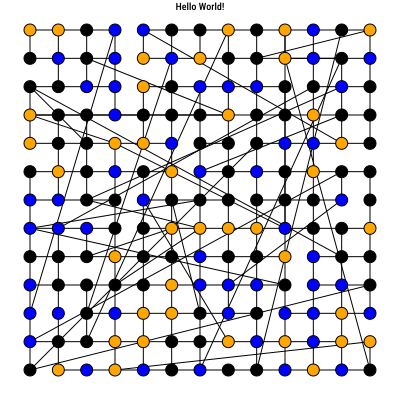

In [161]:
@drawsvg begin
    background("white")
    drawgraph(residential_graph, 
        layout=squaregrid, 
        vertexfillcolors = VertexFillColors(residential_graph, model) )
    Karnak.text( "Hello World!", boxtopcenter() + (0, 10), halign=:center)
end 400 400

In [120]:
function GetAgentNeighborStatus(agent,model)
    count_near = 0
    for pos in nearby_positions( agent.pos , model, r=1)
        count_near += 1
    end
    
    count_neighbors_same_group = 0    
    for neighbor in nearby_agents( agent, model )
        if agent.group == neighbor.group
            count_neighbors_same_group += 1
        end
    end
    return [count_near, count_neighbors_same_group]
end
    
    
function GetAgentRemainStatus(agent, model, count_near, count_neighbors_same_group)
        
    if( (count_neighbors_same_group / count_near) <= model.min_remain_percentage )
        return false
    else
        return true
    end
end

GetAgentRemainStatus (generic function with 1 method)

In [11]:
function agent_step!(agent, model)
    
    count_near, count_neighbors_same_group = GetAgentNeighborStatus(agent, model)
    
    agent.remain = GetAgentRemainStatus(agent, model, count_near, count_neighbors_same_group)

    if agent.remain == false
        #move to random position
        move_agent_single!(agent, model)
        
    end
    
end

agent_step! (generic function with 1 method)

In [12]:
nagents(model)

127

### Visualize Agents Network

In [13]:
NearbyAgent = []
new_row = []
for agent in allagents(model)
    agent_step!(agent, model)
#     println("ID:", agent.id)
#     println("Remain:", agent.remain)
#     println("Group:",agent.group)
#     println("Near by agents:", length( collect( nearby_agents(agent,model) ) ) )
    for nearby in collect(nearby_agents(agent,model))
        push!(new_row, nearby.id) 
    end
    push!(NearbyAgent, new_row)
    new_row = []
end

In [14]:
nearbyGraph = SimpleGraph(length(NearbyAgent))
totaledge = 0
for (i, agent) in enumerate(NearbyAgent)
    for id in agent
        add_edge!(nearbyGraph, i, id)
        totaledge +=1
    end
end

In [15]:
totaledge

456

In [16]:
barabasi_albert(100, 1)

{100, 99} undirected simple Int64 graph

In [17]:
nearbyGraph = barabasi_albert(100, 1)

{100, 99} undirected simple Int64 graph

In [18]:
g = star_graph(20)
rem_vertex!(g, 1)

true

In [19]:
@drawsvg begin
    background("black")
    sethue("white")
    drawgraph(g, layout=stress)
end

LoadError: LoadError: UndefVarError: @drawsvg not defined
in expression starting at In[19]:1

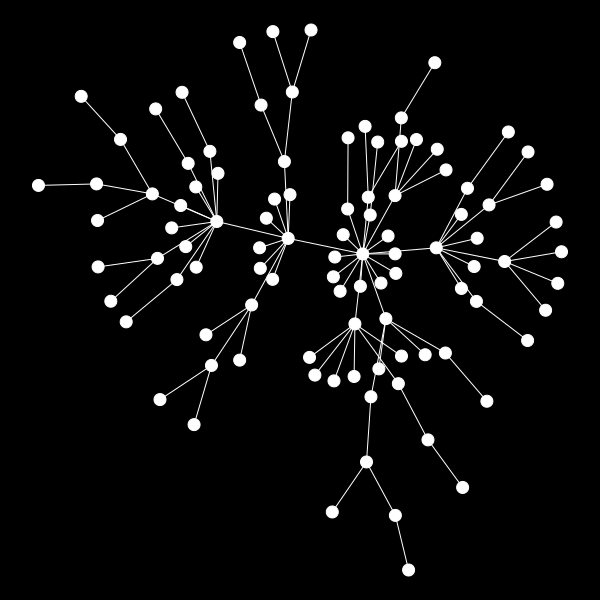

In [20]:
using Karnak
using Graphs
using NetworkLayout
g = barabasi_albert(100, 1)
@drawsvg begin
    background("black")
    sethue("white")
    drawgraph(g, layout=stress)
end

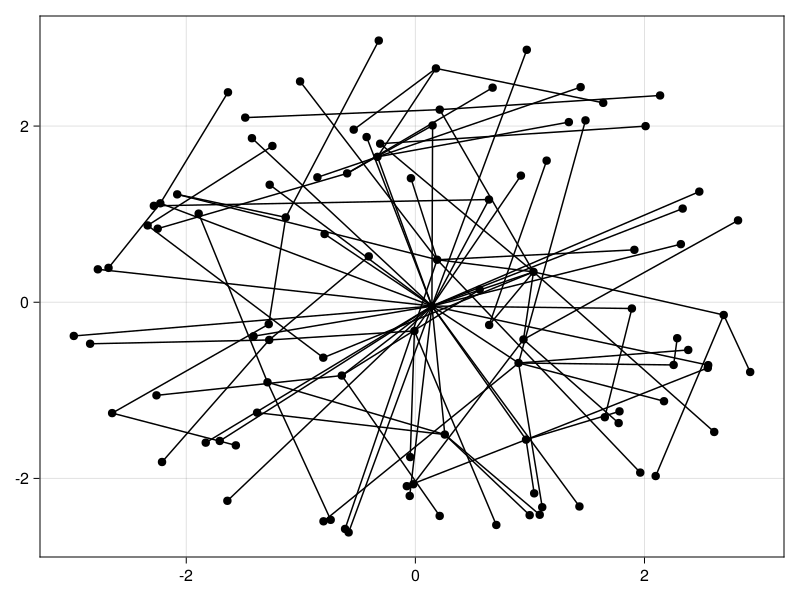

In [21]:
# https://juliagraphs.org/NetworkLayout.jl/stable/
using GLMakie, GraphMakie
using GraphMakie.NetworkLayout


layout1 = SFDP(Ptype=Float32)
f, ax, p = graphplot(nearbyGraph, layout=layout1)

# graphplot(nearbyGraph)

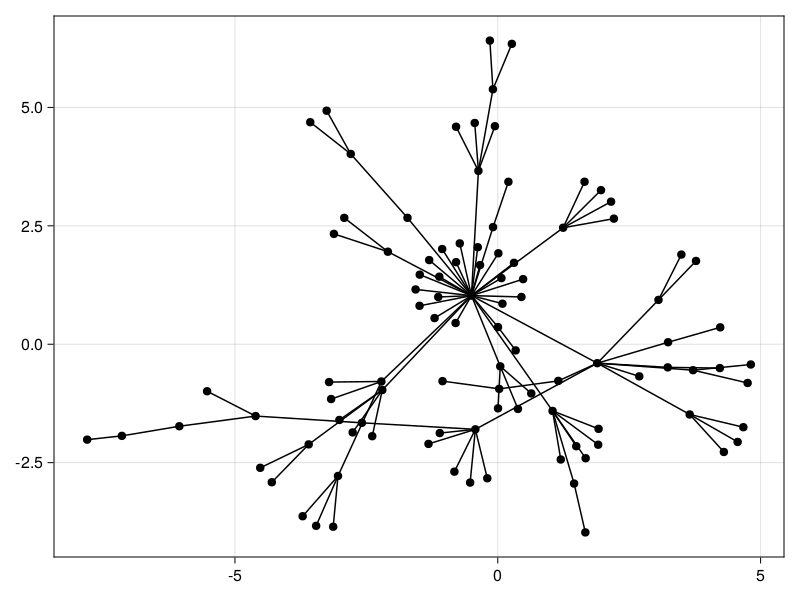

In [22]:
layout2 = Spring(Ptype=Float32)
f, ax, p = graphplot(nearbyGraph, layout=layout2)

In [23]:
iterator1 = LayoutIterator(layout1, nearbyGraph)
record(f, "sfdp_animation.mp4", iterator1; framerate = 10) do pos
    p[:node_pos][] = pos
    autolimits!(ax)
end

"sfdp_animation.mp4"

In [24]:
iterator2 = LayoutIterator(layout2, nearbyGraph)
record(f, "spring_animation.mp4", iterator2; framerate = 10) do pos
    p[:node_pos][] = pos
    autolimits!(ax)
end

"spring_animation.mp4"

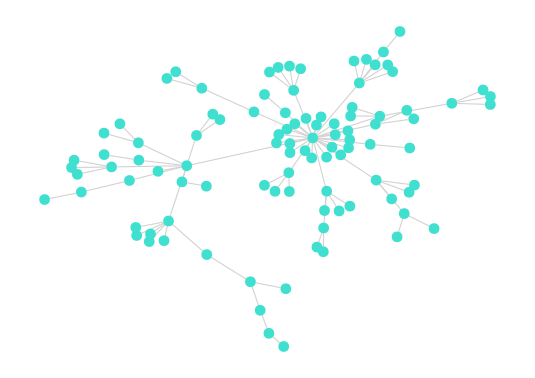

In [25]:
gplot(nearbyGraph)

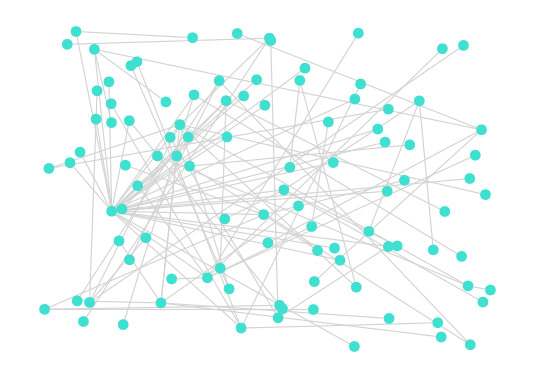

In [26]:
gplot(nearbyGraph, layout=random_layout)

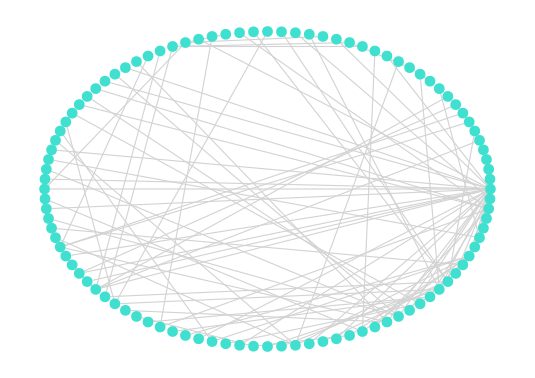

In [27]:
gplot(nearbyGraph, layout=circular_layout)

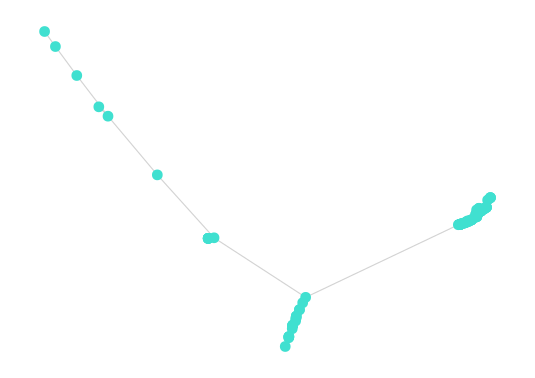

In [28]:
gplot(nearbyGraph, layout=spectral_layout)

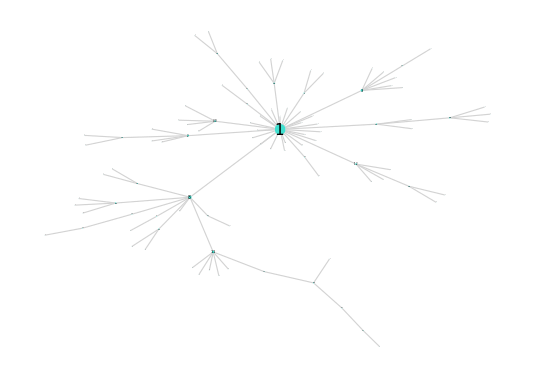

In [29]:
nodelabel = collect(1:nv(nearbyGraph))
nodesize = [Graphs.outdegree(nearbyGraph,v) for v in Graphs.vertices(nearbyGraph)]
gplot(nearbyGraph,nodelabelsize=nodesize, nodelabel=nodelabel, nodesize=nodesize)

In [30]:
draw(PDF("agentGraph.pdf", 25cm, 25cm), gplot(nearbyGraph,nodelabelsize=nodesize, nodelabel=nodelabel, nodesize=nodesize))

LoadError: UndefVarError: cm not defined

In [31]:
residential_graph

{169, 312} undirected simple Int64 graph